In [27]:
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image, ImageEnhance
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import PIL.ImageOps    
from sklearn.metrics import f1_score

In [28]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [48]:
training_dir = "/home/care1e55/study/DBO/project/data/train"
testing_dir = "/home/care1e55/study/DBO/project/data/test"
training_csv="/home/care1e55/study/DBO/project/clean/train_combined_constrative_data.csv"    
testing_csv="/home/care1e55/study/DBO/project/clean/test_combined_constrative_data.csv"

train_batch_size = 48
train_number_epochs = 12

In [49]:
# class Config():
#     training_dir = "/home/care1e55/study/DBO/project/sign_data/train/"
#     testing_dir = "/home/care1e55/study/DBO/project/sign_data/test/"
#     training_csv="/home/care1e55/study/DBO/project/clean/train_sign_constrative_data.csv"
#     testing_csv="/home/care1e55/study/DBO/project/clean/test_sign_constrative_data.csv"

#     train_batch_size = 48
#     train_number_epochs = 12

In [50]:
# training_dir = "/home/care1e55/study/DBO/project/sign_data/train/"
# testing_dir = "/home/care1e55/study/DBO/project/sign_data/test/"
# training_csv="/home/care1e55/study/DBO/project/clean/train_sign_constrative_data.csv"
# testing_csv="/home/care1e55/study/DBO/project/clean/test_sign_constrative_data.csv"

In [51]:
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [52]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):        
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        img0 = Image.open(image1_path).convert('L')
        img1 = Image.open(image2_path).convert('L')
        img0 = ImageEnhance.Contrast(img0).enhance(1.5)
        img1 = ImageEnhance.Contrast(img1).enhance(1.5)
        img0 = ImageEnhance.Brightness(img0).enhance(1.5)
        img1 = ImageEnhance.Brightness(img1).enhance(1.5)
        img0 = PIL.ImageOps.invert(img0)
        img1 = PIL.ImageOps.invert(img1)
        img0 = img0.convert('RGB')
        img1 = img1.convert('RGB')
        img0.load()
        img1.load()

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [53]:
transform = transforms.Compose([
  transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
  # transforms.RandomRotation(degrees = 15, fill=0),
  transforms.RandomAffine(
    degrees=(-5, 5), 
    translate=None, 
    scale=None, 
    shear=(-10,10), 
    resample=False, 
    fillcolor=(0,0,0)),
  transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
  transforms.ToTensor(),
  # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [56]:
# siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,transform=transform)
siamese_dataset = SiameseNetworkDataset(testing_csv,testing_dir,transform=transform)

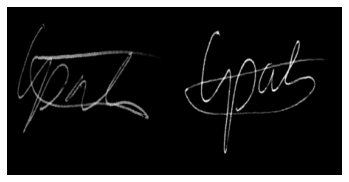

[[1.]]


In [57]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [58]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=False)
        # self.resnet = models.resnet50(pretrained=False)
        set_parameter_requires_grad(self.resnet)
        # self.resnet.avgpool = AdaptiveMaxPool2d(output_size=(1, 1))
        self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                # nn.Linear(num_ftrs, 128),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                nn.Linear(1024, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                # # nn.Linear(128,16)
                # nn.Linear(128,2)
            )
        
    def forward_once(self, x):
        output = self.resnet(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [59]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True

In [60]:
# net = SiameseNetwork().cuda()
# train_dataset = SiameseNetworkDataset(training_csv=training_csv, training_dir=training_dir, transform=transform)
net = SiameseNetwork().cuda()
train_dataset = SiameseNetworkDataset(training_csv=testing_csv, training_dir=testing_dir, transform=transform)

In [61]:
print(net)

SiameseNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [62]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1-label) * torch.pow(euclidean_distance, 2) + 
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
                )
        return loss_contrastive

In [63]:
if torch.cuda.is_available():
    print('Yes')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Yes


In [64]:
def fit_epoch(net, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for i, data in tqdm(enumerate(train_loader,0), total = len(train_loader)):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        running_loss += loss_contrastive.item() * data[0].size(0)
        processed_data += data[0].size(0)
        # if i %50 == 0 :
            # print("Current loss {}\n".format(loss_contrastive.item()))
    train_loss = running_loss / processed_data
    return train_loss

In [95]:
def train(train_files, net, epochs, batch_size):
    train_dataloader = DataLoader(train_files,
                        shuffle=True,
                        num_workers=4,
                        batch_size=batch_size)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"

    # with tqdm(desc="epoch", total=epochs) as pbar_outer:
    opt = optim.AdamW(net.parameters(), lr=0.01)
    scheduler = StepLR(opt, step_size=2, gamma=0.5)
    criterion = ContrastiveLoss()

    for epoch in range(epochs):
        train_loss = fit_epoch(net, train_dataloader, criterion, opt)
        print("loss", train_loss)

        scheduler.step()
        history.append((train_loss))
        
        # pbar_outer.update(1)
        print(r"Epoch {epoch} loss: {train_loss}")
            # tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss))
            
    return history

In [96]:
history = train(train_dataset, net=net, epochs=5, batch_size=48)

100%|██████████| 502/502 [07:40<00:00,  1.09it/s]loss 1.0070911566475798
Epoch {epoch} loss: {train_loss}

100%|██████████| 502/502 [07:49<00:00,  1.07it/s]loss 1.004727972962464
Epoch {epoch} loss: {train_loss}

100%|██████████| 502/502 [07:50<00:00,  1.07it/s]loss 0.9906206346065819
Epoch {epoch} loss: {train_loss}

100%|██████████| 502/502 [07:53<00:00,  1.06it/s]loss 0.9931236359521203
Epoch {epoch} loss: {train_loss}

  2%|▏         | 9/502 [00:09<08:49,  1.07s/it]


KeyboardInterrupt: 

In [98]:
torch.save(net.state_dict(), "/home/care1e55/study/DBO/project/models/contrastive_model.pt")
print("Model Saved Successfully")

Model Saved Successfully


In [99]:
transform = transforms.Compose([
transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
              transforms.ToTensor()
          ])

In [100]:
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,                                     transform=transform)

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

In [101]:
from tqdm import tqdm

In [105]:
for t in np.arange(0.8,1.2,0.2):
    targets = []
    predictions = []
    list_0 = torch.FloatTensor([[0]])
    list_1 = torch.FloatTensor([[1]])
    threshhold = torch.FloatTensor([t]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1 , label = data
        output1,output2 = net(x0.to(device),x1.to(device))
        eucledian_distance = F.pairwise_distance(output1, output2)
        if label==list_0:
            targets.append(0)
        else:
            targets.append(1)
        
        if eucledian_distance <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)
    n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print()
    print(f"{t} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{t} f1:", f1_score(n_targets, n_predictions, average='weighted'))


  0%|          | 0/24093 [00:00<?, ?it/s]
0.8 acc: 0.724982360021583
0.8 f1: 0.7259131848187687
100%|██████████| 24093/24093 [05:47<00:00, 69.25it/s]
1.0 acc: 0.7418752334703026
1.0 f1: 0.7375677272652402



In [104]:
from sklearn.metrics import f1_score

In [61]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.6288137544613731

In [62]:
f1_score(n_targets, n_predictions, average='weighted')

0.6178077664859537

In [63]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.5244630071599046

In [64]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
n_false_predictions.astype('int').sum()/n_false_targets.astype('int').sum()

0.756246529705719

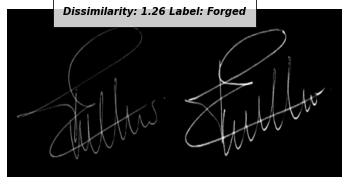

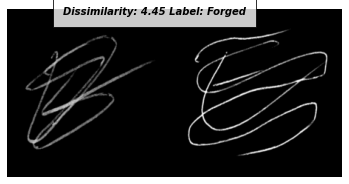

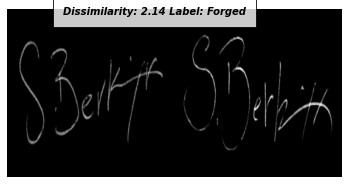

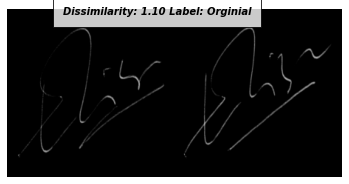

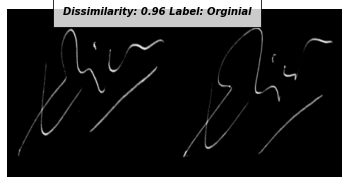

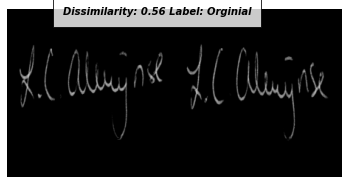

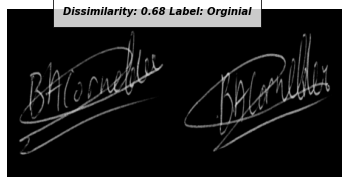

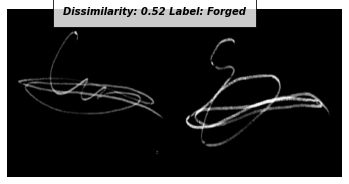

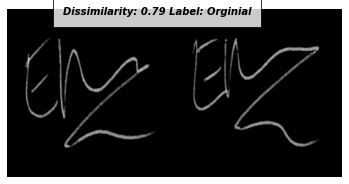

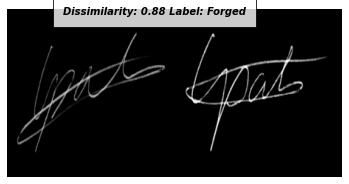

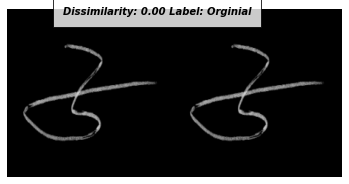

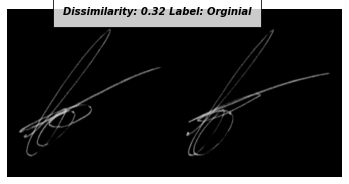

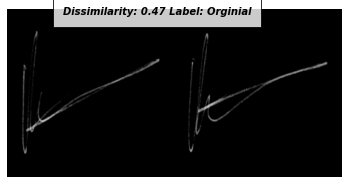

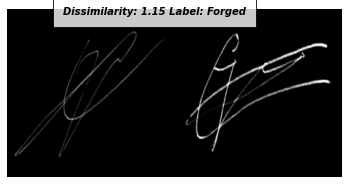

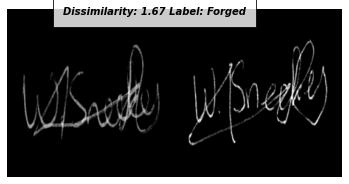

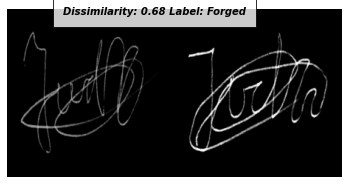

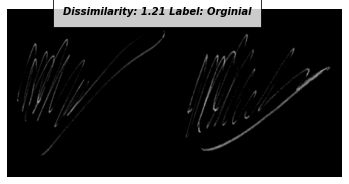

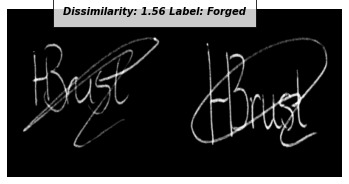

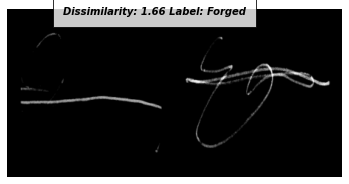

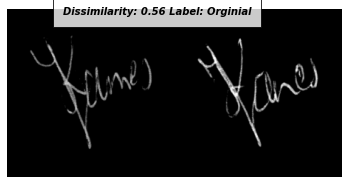

In [97]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = net(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break